In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import sklearn

## Required package versions

In [2]:
sns.__version__

'0.12.2'

In [3]:
np.__version__

'1.18.1'

In [4]:
pd.__version__

'1.0.1'

In [5]:
import matplotlib
matplotlib.__version__

'3.1.3'

In [61]:
import scipy
scipy.__version__

'1.4.1'

## Demo EDA pipeline
**Two examples:**


1) Iris dataset, low dimensional and only numerical vars.

2) Wine datset, higher dimensional and mixed numerical and categorical vars.

Both are formatted as pandas dataframes, with a column named 'target' that specifies the training label of interest.

In [105]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine

In [106]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

In [107]:
iris = load_iris()

In [108]:
data = sklearn_to_df(iris)

In [109]:
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [110]:
# this pipeline accepts a pandas dataframe and the name of the categorical target variable in the provided dataframe
# this pipeline was intended for prepping data for classification tasks, so numeric targets are not accepted at this time
# optional: provide categorical variable frequency cut off (currently at 5% or higher frequency in target population), whether to merge or exclude outliers 
# (default is exclude) and whether to use plotly or seaborn for figures (default is seaborn)

class EDA:
    def __init__(self, df, target, outlier_threshold=0.05, merge_outliers=False, use_plotly=False):
        
        # original dataset, pre-processed
        self.original_data = df
        self.original_data = self.original_data[self.original_data.columns[:len(df.columns)]]
        # dataframe that will be updated post outlier cleanup / normalization
        self.df = df
        self.target = target
        self.outlier_threshold = outlier_threshold
        self.merge_outliers = merge_outliers
        self.use_plotly = use_plotly
        self.pair_plot_cols=self.original_data.select_dtypes(include=np.number).columns.tolist()
        self.outliers = {}
        
        # run exploratory data analysis pipeline
        self.apply_eda()
        
    def pair_plot(self):
        #numerical = self.original_data.select_dtypes(include=np.number).columns.tolist()
        sns.pairplot(self.original_data[self.pair_plot_cols],hue=self.target)
        
    def update_pair_plot(self, variable_list):
        self.pair_plot_cols = variable_list
        return variable_list
    
    def eda_numerical(self, column):
        
        print(f"Descriptive Statistics for {column}:\n{self.df[column].describe()}\n")
        print(f"Number of missing values in {column}: {self.df[column].isnull().sum()}\n")
        
        # z score the data and return the absolute value
        self.df[column+'_zscore'] = np.abs(zscore(self.df[column]))

        # identify outliers beyond z 3 in either direction. extreme outliers considered pts plus minus 5
        outliers = self.df[self.df[column+'_zscore'] > 3]
        extreme_outliers = outliers[outliers[column+'_zscore'] > 5]

        # either replace outliers with the median, or remove entirely
        if self.merge_outliers:
            self.df.loc[self.df[column+'_zscore'] > 3, column] = self.df[column].median()
        else:
            self.df = self.df[self.df[column+'_zscore'] <= 3]
            
        # store information about the outliers from this column in the outliers dictionary
        self.outliers[column] = {'variable_type': 'numerical', 
                                       'num_outliers': outliers.shape[0], 
                                       'num_extreme_outliers': extreme_outliers.shape[0], 'outliers':outliers, 'extreme_outliers':extreme_outliers}

        # normalize the data and return to the dataframe
        self.df[column+'_norm'] = (self.df[column] - self.df[column].min()) / (self.df[column].max() - self.df[column].min())
        
        # plot normalized data
        print('plotting normalized data')
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
        if self.use_plotly:
            fig = px.histogram(self.df, x=column+'_norm')
            fig.show()

            fig = px.box(self.df, y=column+'_norm')
            fig.show()
        else:
            sns.histplot(data=self.df, x=column+'_norm',ax=ax[0])
            sns.boxplot(data=self.df, y=column+'_norm',ax=ax[1])
            plt.tight_layout()
            plt.show()
            
        return self.outliers[column]
    
        
    def eda_categorical(self, var, copy=False):
   
        # frequency analysis
        value_counts = self.df[var].value_counts()
        print(f"Frequency counts for {var}:\n{value_counts}\n")

        # calculate the outlier count threshold based on the percentage (if 100 samples total, as default remove categories with less than 5 entries)
        outlier_count = int(self.outlier_threshold * self.df.shape[0])

        # outlier detection, return list of categories under the threshold
        rare_values = value_counts[value_counts <= outlier_count].index.tolist()
        print(f"Outliers detected in {var}: {rare_values}\n")

        # copy the dataframe
        df_copy = self.df.copy()

        # if True, merge the outliers into 'Other' category, else just remove them
        if self.merge_outliers:
            df_copy[var] = df_copy[var].apply(lambda x: 'Other' if x in rare_values else x)
            print(f"After merging outliers into 'Other', frequency counts for {var}:\n{df_copy[var].value_counts()}\n")
        else:
            df_copy = df_copy[~df_copy[var].isin(rare_values)]
            print(f"After removing outliers, frequency counts for {var}:\n{df_copy[var].value_counts()}\n")
            
        self.outliers[var] = {'variable_type': 'categorical', 
                                       'value_counts':value_counts,
                                       'num_outliers': outlier_count, 
                                       'rare_values': rare_values}

        # plot the data with seaborn
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))

        sns.countplot(x=var, data=df_copy, ax=ax[0])
        ax[0].set_title(f'Distribution of {var}')
        ax[0].tick_params(axis='x', rotation=90)

        sns.countplot(x=self.target, hue=var, data=df_copy, ax=ax[1])
        ax[1].set_title(f'{var} vs {self.target}')
        ax[1].tick_params(axis='x', rotation=90)

        plt.tight_layout()
        plt.show()

        if copy:
            print(f"Copy of dataframe with changes:\n{df_copy}")
        else:
            self.df = df_copy
        
        return self.outliers[var]
    
    def gen_run_label(self,cat=True):
        if cat:
            print('#' * 20)
            print('CATEGORICAL VARIABLE ANALYSIS')
            print('#'* 20, '\n')
        else:
            print('#' * 20)
            print('NUMERICAL VARIABLE ANALYSIS')
            print('#'* 20, '\n')

    def apply_eda(self):
        
        categorical_vars = self.df.select_dtypes(include=['category','int','object']).columns.tolist()
        numerical_vars = self.df.select_dtypes(include=np.number).columns.tolist()
        
        if len(categorical_vars) > 1:
            self.gen_run_label()
            for var in categorical_vars:
                if var == self.target:
                    continue
                else:
                    self.eda_categorical(var)
        else:
            print('No categorical data available\n')

        if len(numerical_vars) > 0:
            self.gen_run_label(False)
            for var in numerical_vars:
                if var == self.target:
                    continue
                else:
                    self.eda_numerical(var)
            
            self.pair_plot()
        else:
            print('\nNo numerical data available')
                


No categorical data available

####################
NUMERICAL VARIABLE ANALYSIS
#################### 

Descriptive Statistics for sepal length (cm):
count    150.000000
mean       5.843333
std        0.828066
min        4.300000
25%        5.100000
50%        5.800000
75%        6.400000
max        7.900000
Name: sepal length (cm), dtype: float64

Number of missing values in sepal length (cm): 0

plotting normalized data


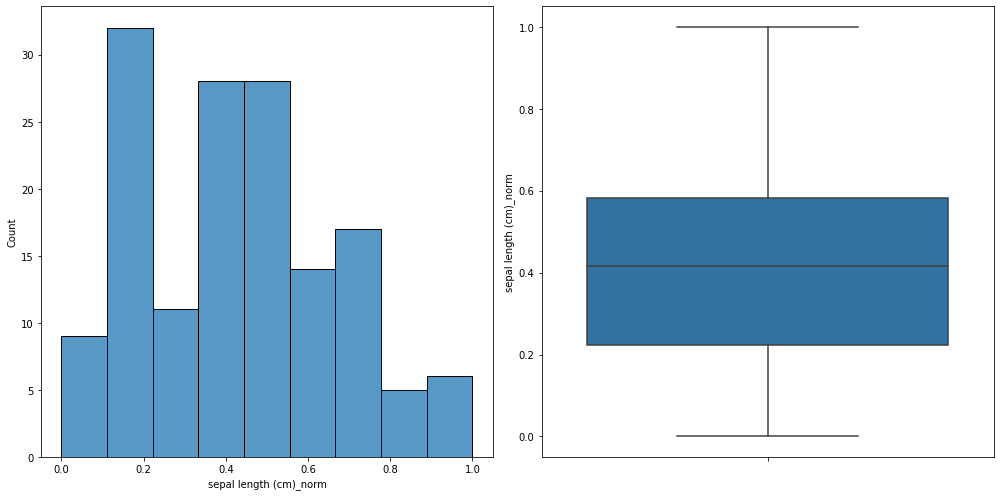

Descriptive Statistics for sepal width (cm):
count    150.000000
mean       3.057333
std        0.435866
min        2.000000
25%        2.800000
50%        3.000000
75%        3.300000
max        4.400000
Name: sepal width (cm), dtype: float64

Number of missing values in sepal width (cm): 0

plotting normalized data


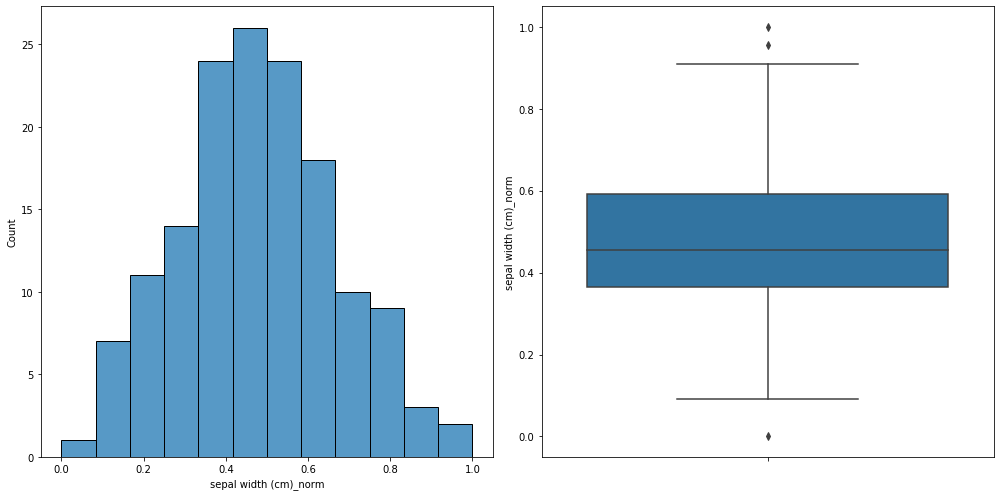

Descriptive Statistics for petal length (cm):
count    149.000000
mean       3.773154
std        1.761435
min        1.000000
25%        1.600000
50%        4.400000
75%        5.100000
max        6.900000
Name: petal length (cm), dtype: float64

Number of missing values in petal length (cm): 0

plotting normalized data


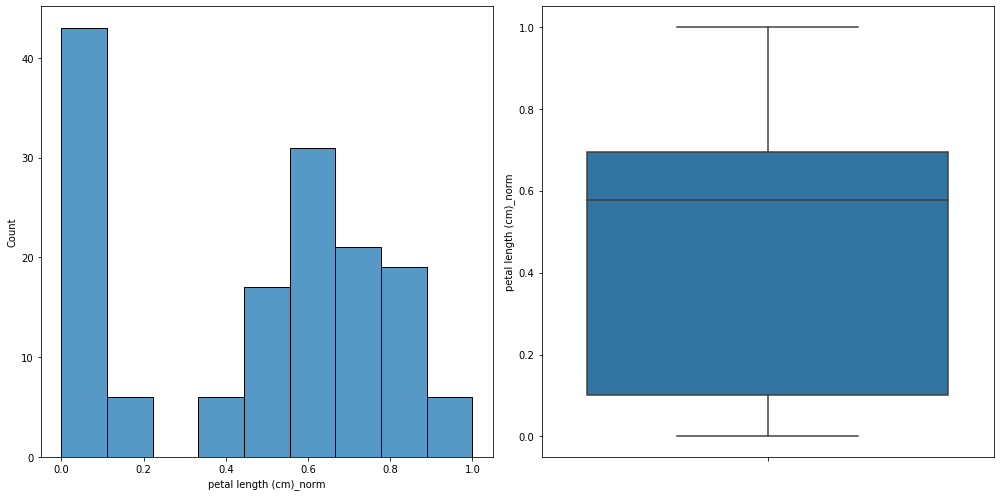

Descriptive Statistics for petal width (cm):
count    149.000000
mean       1.204698
std        0.761962
min        0.100000
25%        0.300000
50%        1.300000
75%        1.800000
max        2.500000
Name: petal width (cm), dtype: float64

Number of missing values in petal width (cm): 0

plotting normalized data


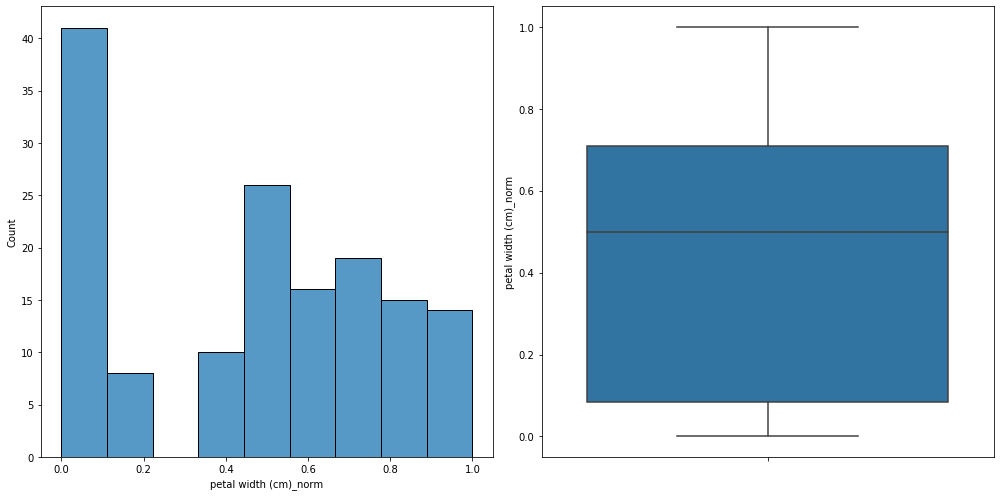

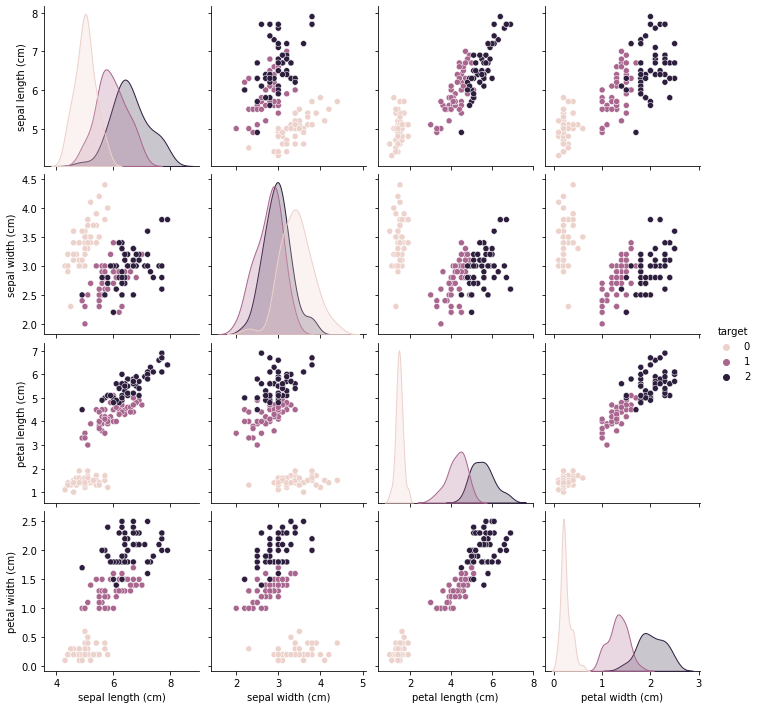

In [111]:
analysis = EDA(df=data,target='target')

## Pipeline gives access to transformed dataframe with normalized data and z-scores for numerical variables

In [112]:
analysis.df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,sepal length (cm)_zscore,sepal length (cm)_norm,sepal width (cm)_zscore,sepal width (cm)_norm,petal length (cm)_zscore,petal length (cm)_norm,petal width (cm)_zscore,petal width (cm)_norm
0,5.1,3.5,1.4,0.2,0,0.900681,0.222222,1.019004,0.681818,1.351829,0.067797,1.323014,0.041667
1,4.9,3.0,1.4,0.2,0,1.143017,0.166667,0.131979,0.454545,1.351829,0.067797,1.323014,0.041667
2,4.7,3.2,1.3,0.2,0,1.385353,0.111111,0.328414,0.545455,1.408792,0.050847,1.323014,0.041667
3,4.6,3.1,1.5,0.2,0,1.506521,0.083333,0.098217,0.500000,1.294865,0.084746,1.323014,0.041667
4,5.0,3.6,1.4,0.2,0,1.021849,0.194444,1.249201,0.727273,1.351829,0.067797,1.323014,0.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,1.038005,0.666667,0.131979,0.454545,0.812779,0.711864,1.442324,0.916667
146,6.3,2.5,5.0,1.9,2,0.553333,0.555556,1.282963,0.227273,0.698853,0.677966,0.915593,0.750000
147,6.5,3.0,5.2,2.0,2,0.795669,0.611111,0.131979,0.454545,0.812779,0.711864,1.047276,0.791667
148,6.2,3.4,5.4,2.3,2,0.432165,0.527778,0.788808,0.636364,0.926706,0.745763,1.442324,0.916667


## Access original dataset after running pipeline

In [113]:
analysis.original_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


## Access pairplot only, and provide columns of interest

In [114]:
vis = ['sepal length (cm)','petal width (cm)', 'target']

In [115]:
analysis.update_pair_plot(vis)

['sepal length (cm)', 'petal width (cm)', 'target']

In [116]:
analysis.pair_plot_cols

['sepal length (cm)', 'petal width (cm)', 'target']

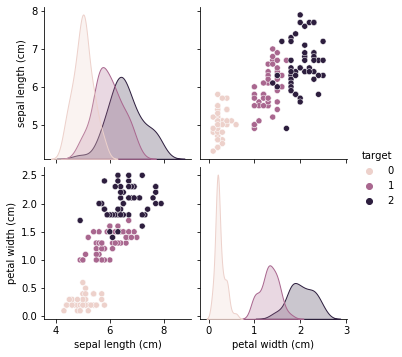

In [117]:
analysis.pair_plot()

## Example 2: Wine dataset

In [118]:
wine = load_wine()

In [119]:
wi = sklearn_to_df(wine)

In [120]:
wi['hue_categ']=pd.qcut(wi.hue, 3, labels=['lighter','neutral', 'darker'])

In [121]:
wi = wi.drop(columns=['hue'])

In [122]:
wi

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,od280/od315_of_diluted_wines,proline,target,hue_categ
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,3.92,1065.0,0,neutral
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,3.40,1050.0,0,neutral
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,3.17,1185.0,0,neutral
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,3.45,1480.0,0,lighter
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,2.93,735.0,0,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,1.74,740.0,2,lighter
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,1.56,750.0,2,lighter
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,1.56,835.0,2,lighter
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,1.62,840.0,2,lighter


## Integers, objects and category datatypes considered categorical data. Otherwise, numeric.

In [124]:
wi.dtypes

alcohol                          float64
malic_acid                       float64
ash                              float64
alcalinity_of_ash                float64
magnesium                        float64
total_phenols                    float64
flavanoids                       float64
nonflavanoid_phenols             float64
proanthocyanins                  float64
color_intensity                  float64
od280/od315_of_diluted_wines     float64
proline                          float64
target                             int64
hue_categ                       category
dtype: object

####################
CATEGORICAL VARIABLE ANALYSIS
#################### 

Frequency counts for hue_categ:
neutral    62
lighter    60
darker     56
Name: hue_categ, dtype: int64

Outliers detected in hue_categ: []

After removing outliers, frequency counts for hue_categ:
neutral    62
lighter    60
darker     56
Name: hue_categ, dtype: int64



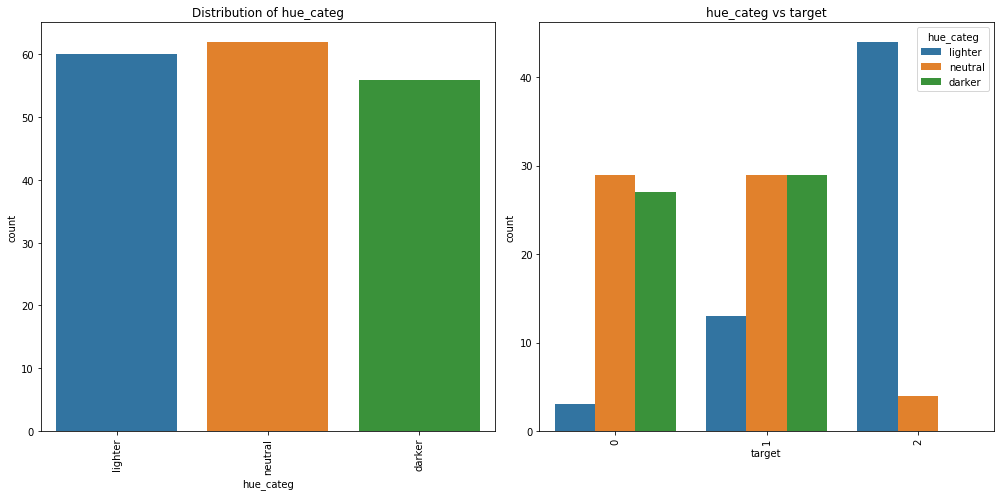

####################
NUMERICAL VARIABLE ANALYSIS
#################### 

Descriptive Statistics for alcohol:
count    178.000000
mean      13.000618
std        0.811827
min       11.030000
25%       12.362500
50%       13.050000
75%       13.677500
max       14.830000
Name: alcohol, dtype: float64

Number of missing values in alcohol: 0

plotting normalized data


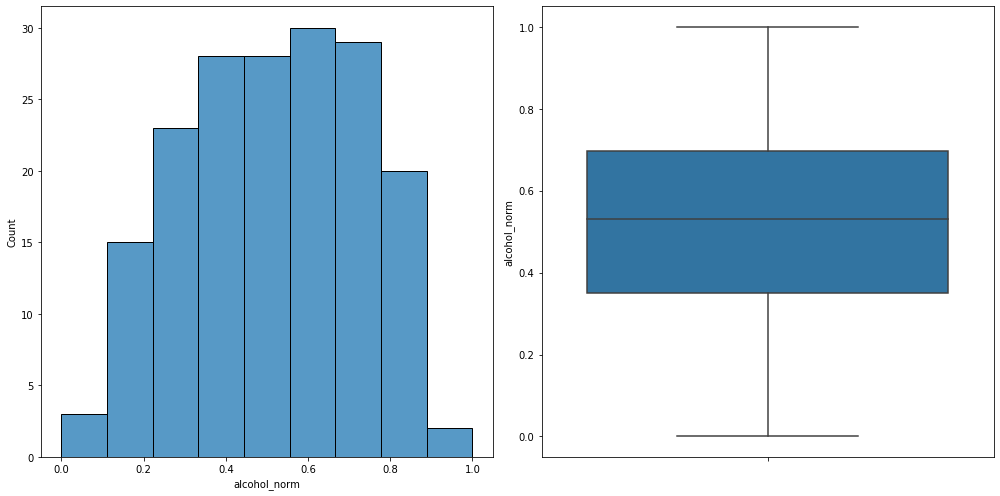

Descriptive Statistics for malic_acid:
count    178.000000
mean       2.336348
std        1.117146
min        0.740000
25%        1.602500
50%        1.865000
75%        3.082500
max        5.800000
Name: malic_acid, dtype: float64

Number of missing values in malic_acid: 0

plotting normalized data


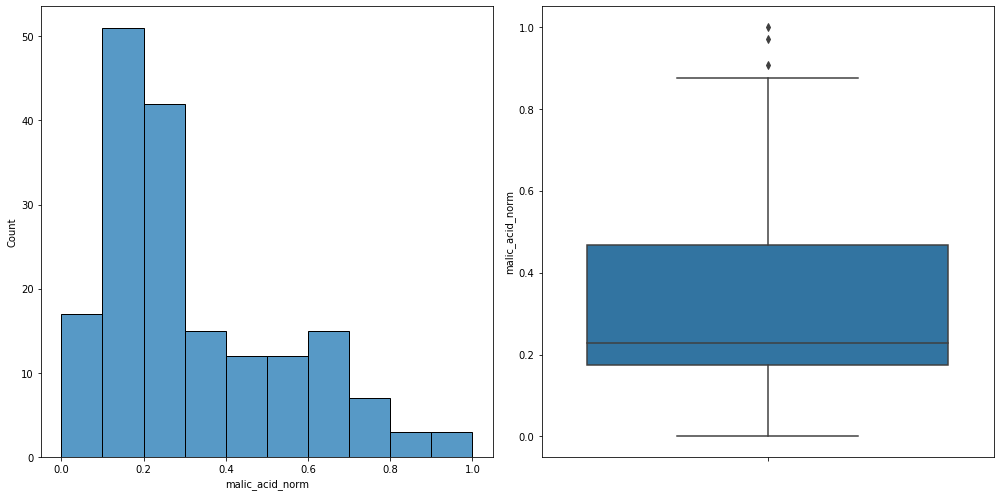

Descriptive Statistics for ash:
count    177.000000
mean       2.367853
std        0.274541
min        1.360000
25%        2.210000
50%        2.360000
75%        2.560000
max        3.230000
Name: ash, dtype: float64

Number of missing values in ash: 0

plotting normalized data


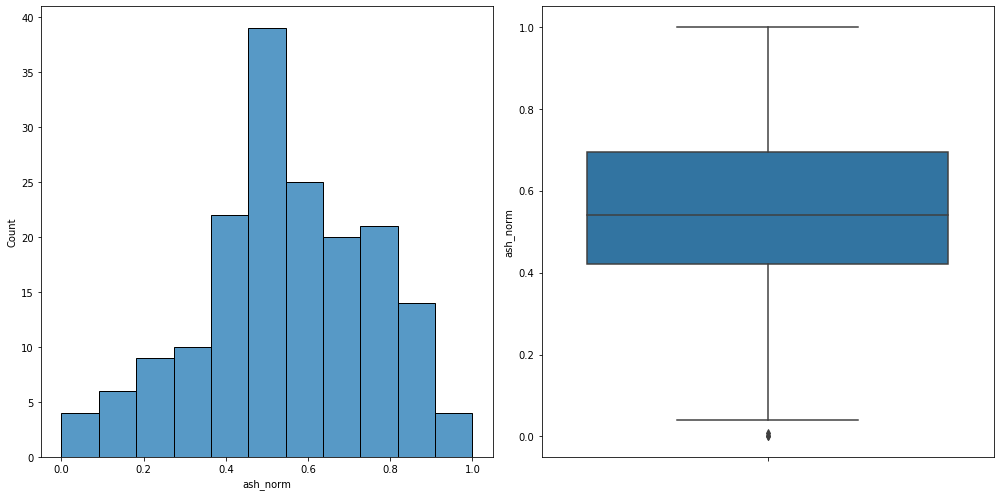

Descriptive Statistics for alcalinity_of_ash:
count    174.000000
mean      19.451149
std        3.206888
min       11.200000
25%       17.200000
50%       19.450000
75%       21.500000
max       30.000000
Name: alcalinity_of_ash, dtype: float64

Number of missing values in alcalinity_of_ash: 0

plotting normalized data


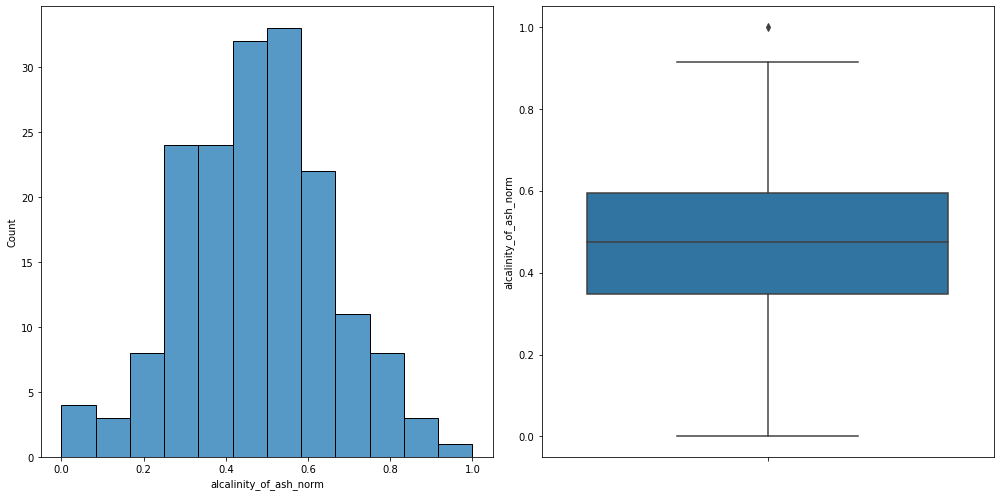

Descriptive Statistics for magnesium:
count    173.000000
mean      99.410405
std       13.905800
min       70.000000
25%       88.000000
50%       98.000000
75%      107.000000
max      162.000000
Name: magnesium, dtype: float64

Number of missing values in magnesium: 0

plotting normalized data


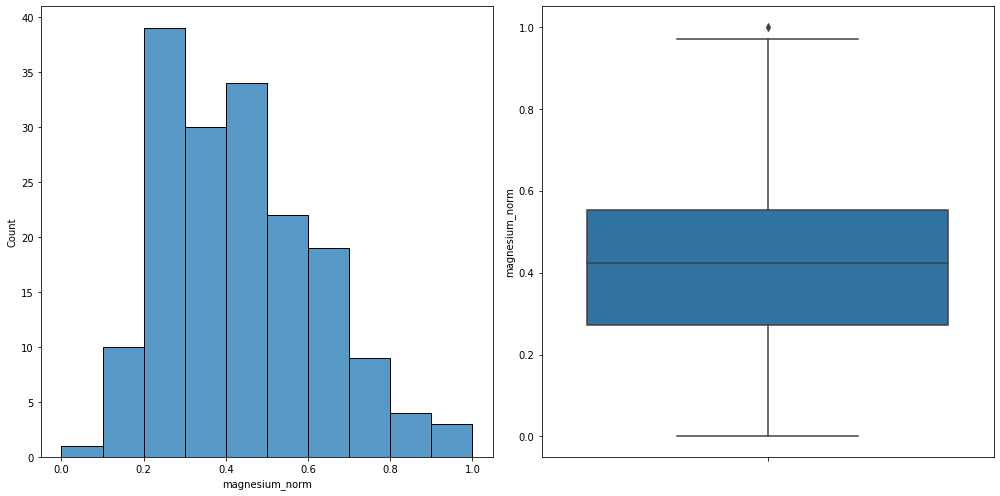

Descriptive Statistics for total_phenols:
count    171.000000
mean       2.283450
std        0.627581
min        0.980000
25%        1.710000
50%        2.320000
75%        2.800000
max        3.880000
Name: total_phenols, dtype: float64

Number of missing values in total_phenols: 0

plotting normalized data


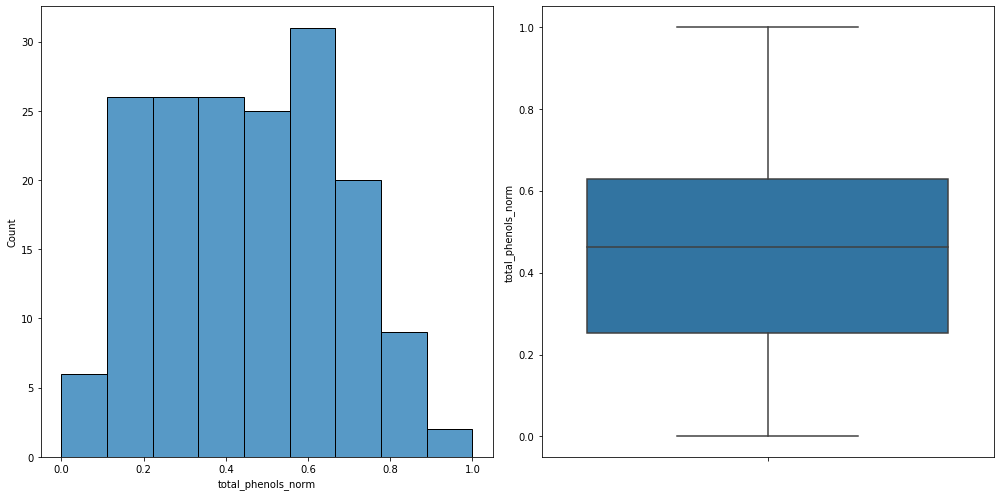

Descriptive Statistics for flavanoids:
count    171.000000
mean       2.010468
std        0.978986
min        0.340000
25%        1.150000
50%        2.110000
75%        2.870000
max        3.930000
Name: flavanoids, dtype: float64

Number of missing values in flavanoids: 0

plotting normalized data


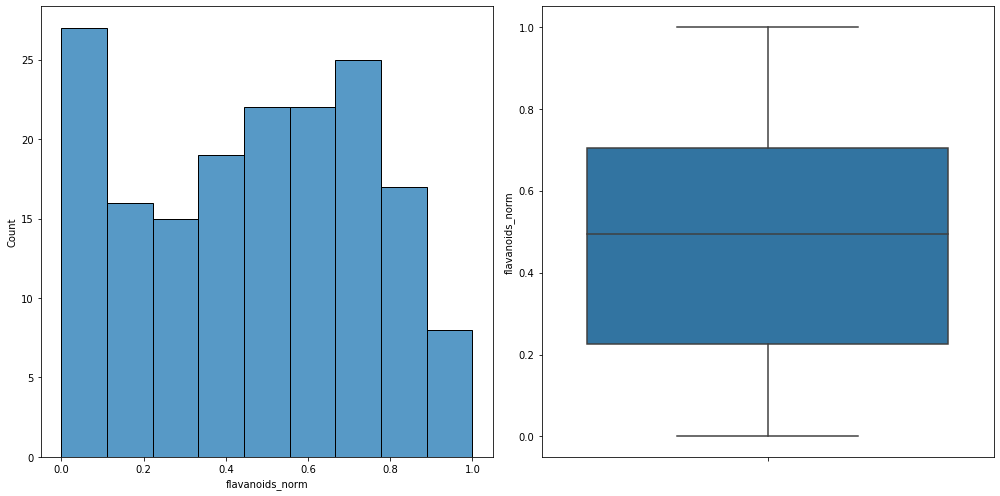

Descriptive Statistics for nonflavanoid_phenols:
count    171.000000
mean       0.363860
std        0.124448
min        0.130000
25%        0.270000
50%        0.340000
75%        0.435000
max        0.660000
Name: nonflavanoid_phenols, dtype: float64

Number of missing values in nonflavanoid_phenols: 0

plotting normalized data


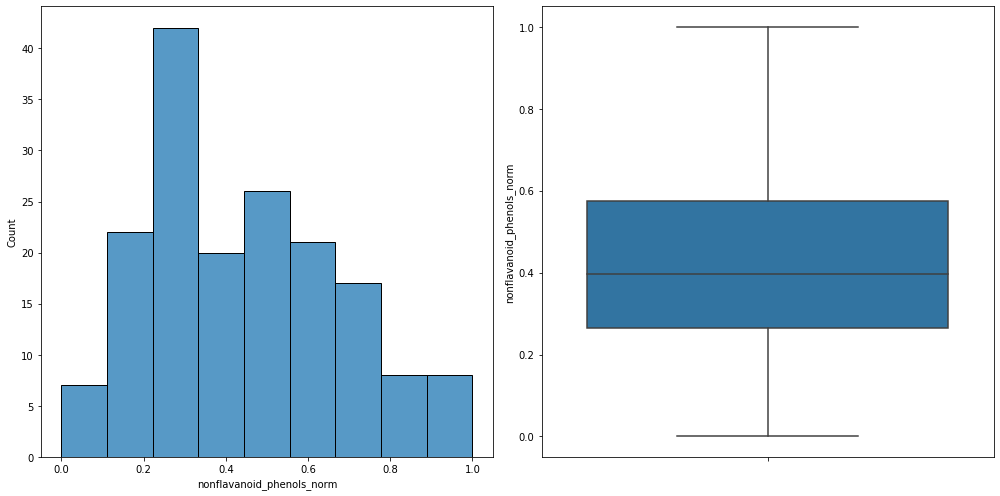

Descriptive Statistics for proanthocyanins:
count    171.000000
mean       1.574386
std        0.555131
min        0.410000
25%        1.245000
50%        1.540000
75%        1.925000
max        3.580000
Name: proanthocyanins, dtype: float64

Number of missing values in proanthocyanins: 0

plotting normalized data


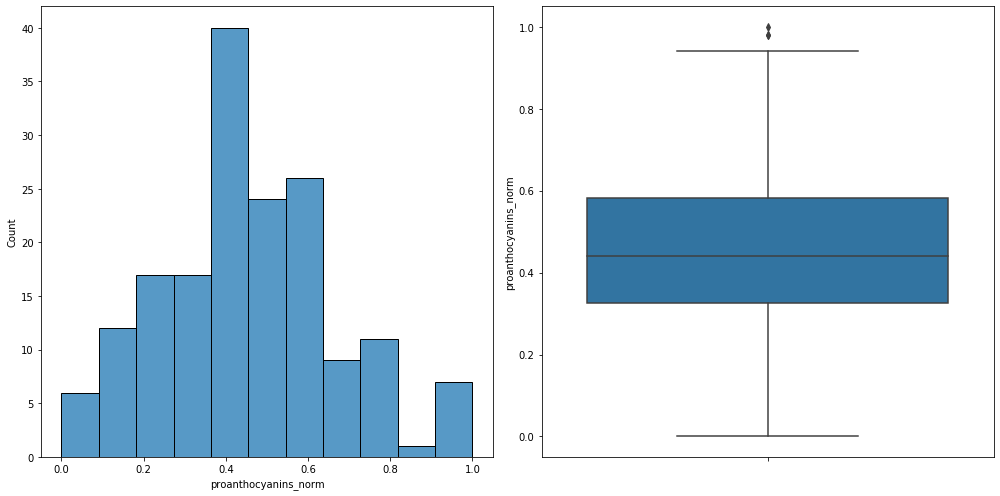

Descriptive Statistics for color_intensity:
count    170.000000
mean       5.144176
std        2.323982
min        1.280000
25%        3.277500
50%        4.850000
75%        6.287500
max       13.000000
Name: color_intensity, dtype: float64

Number of missing values in color_intensity: 0

plotting normalized data


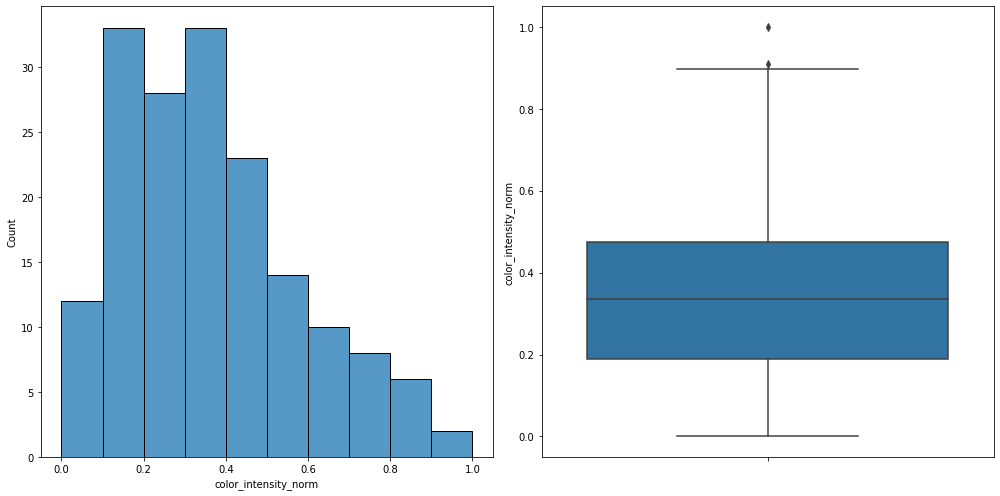

Descriptive Statistics for od280/od315_of_diluted_wines:
count    169.000000
mean       2.598225
std        0.712787
min        1.270000
25%        1.920000
50%        2.780000
75%        3.170000
max        4.000000
Name: od280/od315_of_diluted_wines, dtype: float64

Number of missing values in od280/od315_of_diluted_wines: 0

plotting normalized data


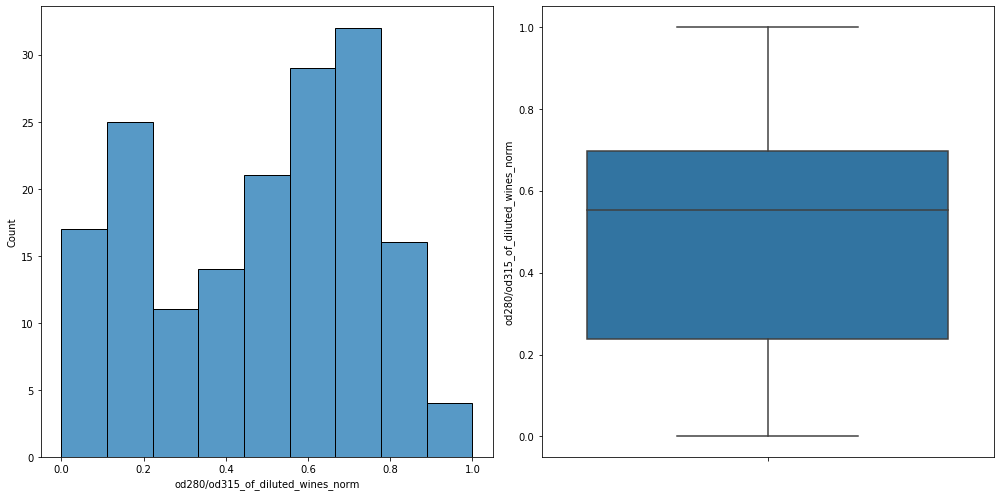

Descriptive Statistics for proline:
count     169.000000
mean      750.828402
std       319.430520
min       278.000000
25%       500.000000
50%       675.000000
75%      1015.000000
max      1680.000000
Name: proline, dtype: float64

Number of missing values in proline: 0

plotting normalized data


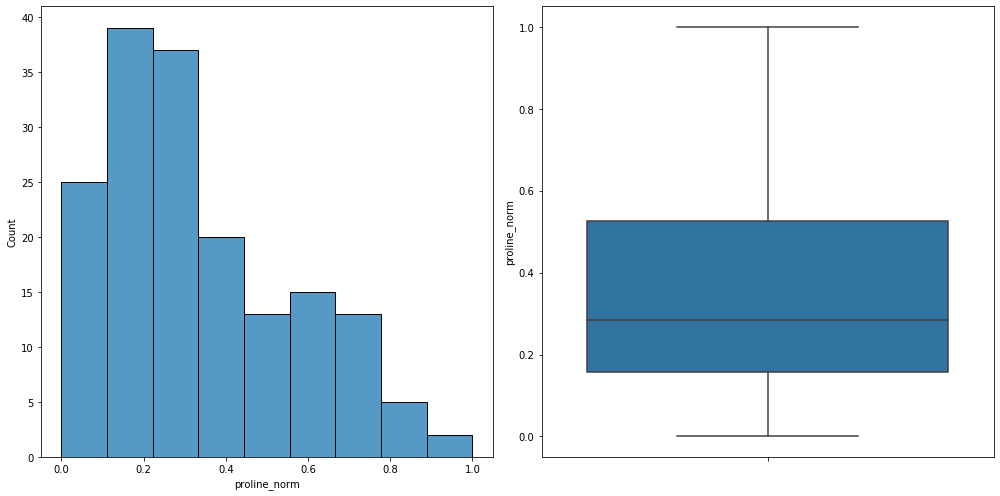

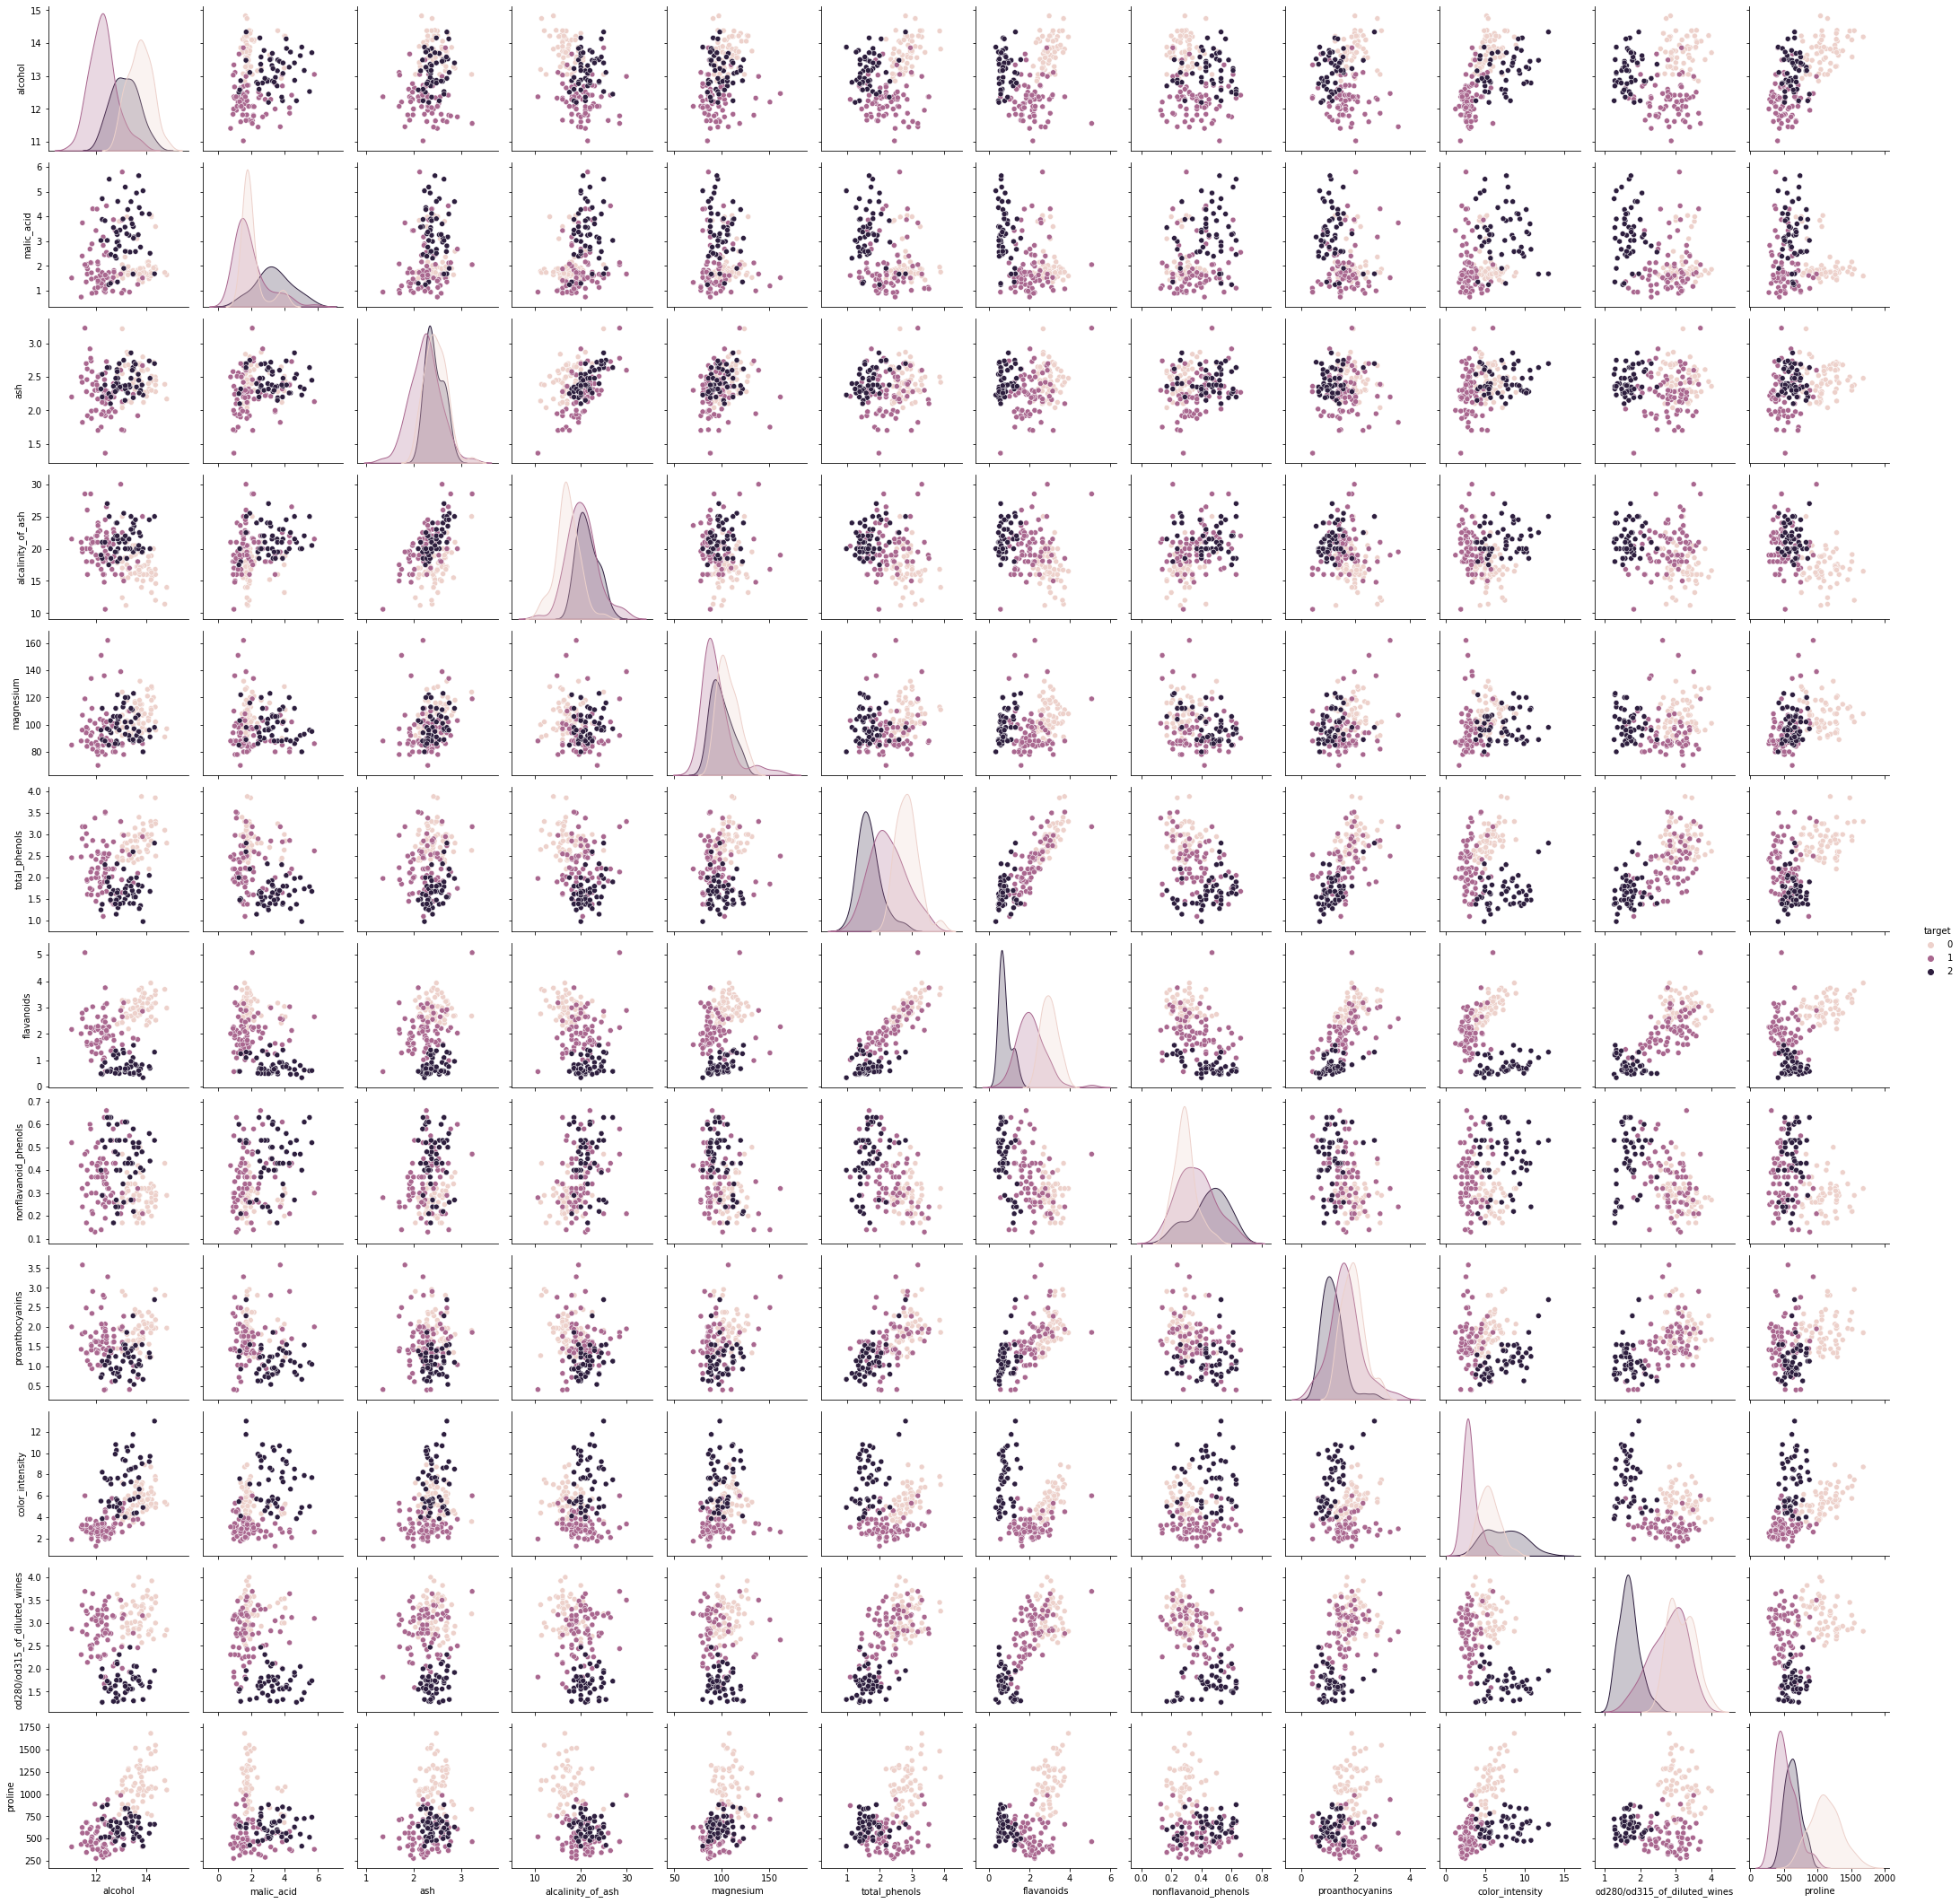

In [125]:
wine_analysis=EDA(df=wi, target='target')

In [126]:
vis = ['alcohol', 'flavanoids', 'total_phenols', 'color_intensity', 'target']
wine_analysis.update_pair_plot(vis)

['alcohol', 'flavanoids', 'total_phenols', 'color_intensity', 'target']

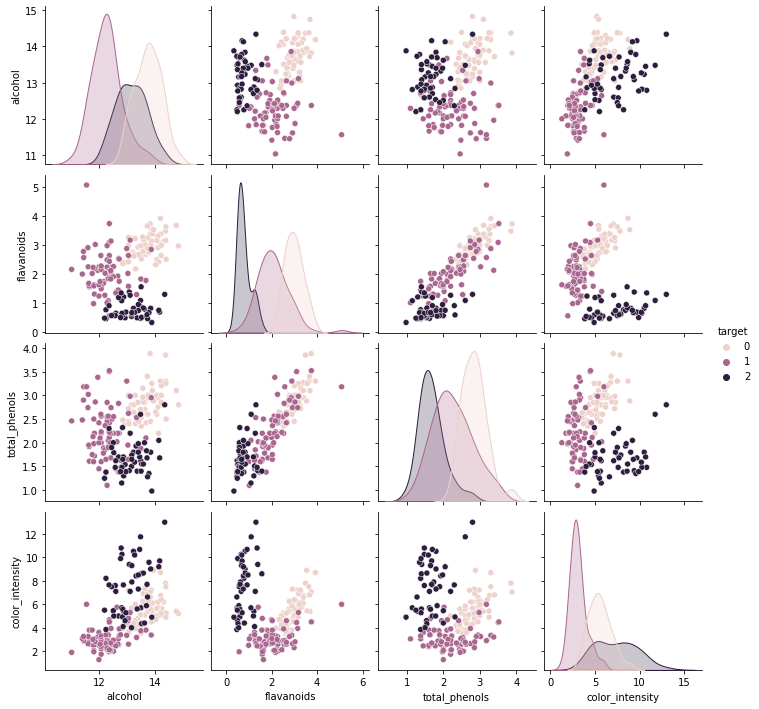

In [130]:
wine_analysis.pair_plot()

## Access information about outliers - stored as a dictionary

In [131]:
wine_analysis.outliers

{'hue_categ': {'variable_type': 'categorical',
  'value_counts': neutral    62
  lighter    60
  darker     56
  Name: hue_categ, dtype: int64,
  'num_outliers': 8,
  'rare_values': []},
 'alcohol': {'variable_type': 'numerical',
  'num_outliers': 0,
  'num_extreme_outliers': 0,
  'outliers': Empty DataFrame
  Columns: [alcohol, malic_acid, ash, alcalinity_of_ash, magnesium, total_phenols, flavanoids, nonflavanoid_phenols, proanthocyanins, color_intensity, od280/od315_of_diluted_wines, proline, target, hue_categ, alcohol_zscore]
  Index: [],
  'extreme_outliers': Empty DataFrame
  Columns: [alcohol, malic_acid, ash, alcalinity_of_ash, magnesium, total_phenols, flavanoids, nonflavanoid_phenols, proanthocyanins, color_intensity, od280/od315_of_diluted_wines, proline, target, hue_categ, alcohol_zscore]
  Index: []},
 'malic_acid': {'variable_type': 'numerical',
  'num_outliers': 1,
  'num_extreme_outliers': 0,
  'outliers':      alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  tot

## Visualize as a dataframe

In [129]:
pd.DataFrame.from_dict(wine_analysis.outliers)

,hue_categ,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,od280/od315_of_diluted_wines,proline
variable_type,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
value_counts,neutral 62 lighter 60 darker 56 Name...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_outliers,8,0,1,3,1,2,0,0,0,1,1,0,0
rare_values,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_extreme_outliers,NaN,0,0,0,0,0,0,0,0,0,0,0,0
outliers,NaN,"Empty DataFrame Columns: [alcohol, malic_acid,...",alcohol malic_acid ash alcalinity_of_...,alcohol malic_acid ash alcalinity_of_...,alcohol malic_acid ash alcalinity_of_as...,alcohol malic_acid ash alcalinity_of_a...,"Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...",alcohol malic_acid ash alcalinity_of_...,alcohol malic_acid ash alcalinity_of_a...,"Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,..."
extreme_outliers,NaN,"Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,...","Empty DataFrame Columns: [alcohol, malic_acid,..."
